

<div style='float: right;'>
    <br/>
    <a href='https://logosmarken.com/wp-content/uploads/2020/05/Uber-Zeichen-2018-Heute.jpg' target='_blank'>
    <img style="float: center;" src='https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Uber_logo_2018.svg/2560px-Uber_logo_2018.svg.png' alt="Uber" width="200" height="300"/>
    <br/>
    </a>
</div>


<left> <h3> Ahmed Tantawy </h3> </left>




## Part 1

### Outline

The goal of the first part of this case study is to obtain a basic pricing algorithm similar to what uber does. The designed algorithm will take coordinates of an origin as well as a destination as input parameters and return the price for the ride. We first define some basic parameters for pricing, e.g. a base price per ride and a minute price depending on the travel time. Next, we calculate the estimated travel time between the given two coordinates. A traffic density model is used to define a traffic weight for working days depending on the hour the user wants to take the ride. For special weather conditions like cold, snowy, or rainy weather, the prices will go up. Therefore, the weather forecast is taken into consideration as well. Last, based on the availability of uber drivers, we add a factor to account for a potential driver scarcity. The final step is to combine the basic pricing with the general duration and add all applicable weights to get a price per ride.


### Disclaimer

During the whole  calculation, we asume that uber is used inside cities to get from A to B. Prices for rides longer than 20 kilometers are very likely to be very high. It might be a good idea to build another pricing model for long-distance rides to better account for this. Nevertheless, for this case study it is assumed that inner-city rides are the main focus of uber.

The pricing is tested using coordinates in Hamburg. Weights and fees are set so that pricing makes sense in this big city. It can be the case that prices are too high or too low for other cities where traffic is different. All weights and fees can easily be changed to adapt to another city's situation without changing the logic of the algorithm.

## Table of Contents:

1. [Basic Assumptions](#basic)
2. [Travel Time](#traveltime)
3. [Driver Scarsity](#drivers)
4. [Traffic Density](#traffic)
5. [Weather Data](#weather)
6. [Pricing Algorithm](#pricing)

### 1. Basic Assumptions

Similar to normal taxi prices, we define a **base price** as well as a **minute price** depending on the travel duration:

In [1]:
basic_fee = 3.0
minute_price = 0.8
print(basic_fee)

3.0


### 2. Travel Time <a class="anchor" id="traveltime"/>

The first part of our pricing model consists of the driving time between two coordinates. We use the **Open Source Routing Machine (OSRM)** for this purpose (see [project-osrm.org](http://project-osrm.org/) and [this](https://github.com/Project-OSRM/osrm-backend/blob/master/docs/http.md) github project).

basic outline:

url = 'http://router.project-osrm.org'

GET /{service}/{version}/{profile}/{coordinates}?option=value&option=value


We make use of the following two python libraries:
* **requests** for the GET request
* **json** to transform the response

In [1]:
import requests as req
import json

### get request


First, we build the url to make the get request:
* The **service** type "table" returns the duration (and distance if specified) of the fastest route between all pairs of supplied coordinates.
* The API **version** is v1.
* The **travel mode (profile)** is driving.
* The **coordinates** will later be defined as input parameters of the algorithm. They are not preset in the url.
* In the **options** of the request, we define the first input coordinates as **source**.
* We want to get the duration and distance as response, so we define this in the **annotations**.

Then, we perform the actual get request and transform the response to duration in minutes.

Note that the outputs are lists with the distances / durations between source and source / destination. Thus, the first list entry is **0.0** in both cases and we only look at the second list element, respectively.

**Remark:** The API seems to be less accurate for short distances. During testing, we noticed that the duration in minutes for rides under 10 km in Hamburg is too short. We thus added an additional factor to the duration in case of a distance under 10 kilometers.

In [2]:
def get_duration_in_min(orig, dest):
    """
    :param orig: origin as coordinates in the form "xx.xxxxxx,yy.yyyyyy" ("lon,lat")
    :param dest: destination as coordinates in the form "xx.xxxxxx,yy.yyyyyy" ("lon,lat")
    :return: duration in minutes to drive from source to destination
    """
    
    # set variables for get request
    service = "table"
    version = "v1"
    profile = "driving"
    optional = "sources=0&annotations=duration,distance"

    # put variables in url
    osrm_url = f"http://router.project-osrm.org/{service}/{version}/{profile}/{{origin}};{{destination}}?{optional}"

    # get request with input coordinates returns the duration(s) in seconds and distance(s) in meters
    response = req.get(url=osrm_url.format(origin=orig, destination=dest))
    
    distances_m = json.loads(response.text).get("distances")[0]
    
    # transform durations to minutes
    durations_sec = json.loads(response.text).get("durations")[0]
    durations_min = [round(x/60,2) for x in durations_sec]
    
    # return first list entries to only get distance and duration between origin and destination
    # add weight to account for inaccuracy of response for short rides
    duration = durations_min[1] * 1.4 if distances_m[1] < 10000 else durations_min[1] 
    return duration

### Caution

**Longitude** is the measurement **east or west** of the prime meridian ([nationalgeographic](https://www.nationalgeographic.org/encyclopedia/latitude)).


**Latitude** is the measurement of distance **north or south** of the Equator ([nationalgeographic](https://www.nationalgeographic.org/encyclopedia/longitude)).

if you search for a address in Germany on Google Maps, the respective coordinates will be of the form **(Lat, Lon)**:

e.g. for "WWU" it is 51.95945106021929N, 7.625524547448689E.

The API endpoints takes coordinates in the form **(Lon, Lat)**, so that any search from Google Maps to test the API has to be swapped before use. (Otherwise, you most likely end up in the Indian Ocean!)



In [3]:
# testing

# Hamburg
hh_hbf = "10.00619701611818,53.55214525925354"
zoo = "9.938501976064497,53.5967893210501"
kiez = "9.962571483020044,53.54969726567535"
elphi = "9.984683128972797,53.541634912662126"
stadtpark = "10.015518238726033,53.59710491208121"

orig = hh_hbf
dest = kiez

get_duration_in_min(orig, dest)

9.17

### 3. Driver Scarcity <a class="anchor" id="drivers"/>

If few drivers are available, prices for a ride will go up. As we do not have current data on drivers available, we add a random variable to account for the scarcity of drivers.

We first define different potential weights:

In [4]:
import numpy as np

# use around to round the entries in the array, otherwise the list contains floats with 16 decimal places
scarcity = list(np.around(np.arange(0.7, 1.3, 0.05),2))

Next, we test how to get a scarcity weight from this list randomly. We will use this approch later on to add a scarcity weight.

In [5]:
import random

random.choice(scarcity)

1.2

### 4. Traffic Density <a class="anchor" id="traffic"/>

For normal working days (mon - fri, no holiday), we now define time windows to account for the traffic density. Assumptions for any bigger city (where uber most likely operates) are as follows:

00:00 - 05:59: low density

06:00 - 09.59: high density (rush hour)

10:00 - 14:59: average to high density

15:00 - 18:59: high density (rush hour)

19:00 - 19:59: average to high density

20:00 - 21:59: average density

22:00 - 23:59: low density

To know when to apply these weights, we first want to check if today (or any input date in our final algorithm) is a working day. We make use of the **datetime** library here.

In [6]:
from datetime import datetime

def is_weekday(req_timestamp = None, input_format = "%Y-%m-%d %H:%M"):
    """
    :param req_timestamp: OTIONAL timestamp as string in the given time format
    :param input_format: format of the input timestamp
    :return: True if working day, False otherwise
    """
    day = datetime.now() if not req_timestamp else datetime.strptime(req_timestamp, input_format)
    return 0 < day.weekday() < 5

In [7]:
#testing
print(is_weekday())
print(is_weekday("2021-12-25 13:00"))

True
False


We next define traffic density weights as follows:

In [8]:
low = 1
avg = 1.1
avg_high = 1.3
high = 1.5

weights = [low] * 6 + [high] * 4 + [avg_high] * 5 + [high] * 4 + [avg_high] * 1 + [avg] * 2 + [low] * 2

We visualize our traffic density model to get a better impression here:

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

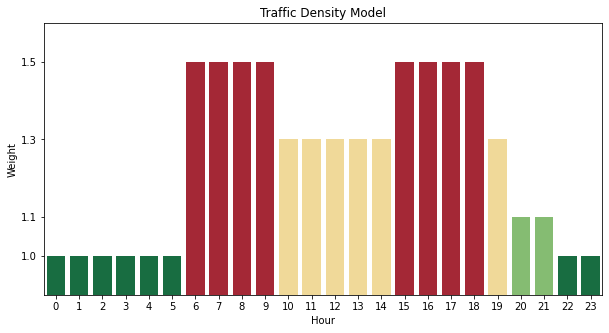

In [10]:
# from https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

# define df for weights and hours per normal working day
hours = np.arange(24)
data = pd.DataFrame(list(zip(hours, weights)), columns =['Hour', 'Weight'])

# define the actual plot
plt.subplots(figsize=(10,5))
ax = sns.barplot(x=data["Hour"], y=data["Weight"], palette=colors_from_values(np.array(weights), "RdYlGn_r"))

# set title and y ticks
ax.set_title('Traffic Density Model')
ax.set_ylim([low-0.1, high+0.1])
ax.set_yticks((low, avg, avg_high, high))

plt.show()

With this model, we define a function to obtain the current traffic's density weight:

In [11]:
# input: "2021-12-28 13:30"
def get_traffic_density_weight(req_timestamp = None, input_format = "%Y-%m-%d %H:%M"):
    """
    :param req_timestamp: OTIONAL timestamp as string in the given time format
    :param input_format: format of the input timestamp
    :return: the traffic density weight for the given timestamp (float)
    """
    if not req_timestamp:
        # take now and transform it to string of format 
        hour = int(datetime.strftime(datetime.utcnow(), format("%H")))
    else:
        hour = int(datetime.strptime(req_timestamp, input_format).strftime("%H"))

    return weights[hour]

In [12]:
# testing
print(get_traffic_density_weight("2021-12-28 05:40"))
print(get_traffic_density_weight())

1
1.3


### 5. Weather Data <a class="anchor" id="weather"/>

We also want to include weather data for the city in which the uber ride is requested. We use the [One Call API](https://openweathermap.org/api/one-call-api) from [Open Weather Map](https://openweathermap.org/api) for this purpose. The API is free to use as long as quotas are met, but we have to sign up to get an API key first. An active api key is included in the code.

We assume that for rainy hours, the traffic as well as demand for uber rides will increase slightly. For cold and icy hours (under 0 degrees celcius or snow), the traffic and uber demand will increase even more. We will include additional weights in our pricing algorithm depending on this weather forecast.

### get request

basic outline for the One Call API:

url = 'https://api.openweathermap.org'

GET /data/2.5/onecall?lat={lat}&lon={lon}&exclude={exclude}&units={units}&appid={my_key}

We build the url to make the get request:
* We need **lat** and **lon** for the city of interest.
* The API response contains data on several levels per default. We only need hourly data and thus **exclude** the rest.
* We want to get the response in metric **units**.

Next, we perform the actual get request. We only need specific data from the response here. Hourly data for the next 48 hours
* unix timestamp **in UTC** of every full hour
* temperature in degrees celcius
* main weather description, e.g. "clear", "snow", "rain"


#### Remark

This API does not work via a VPN-Connection.

In [13]:
import requests as req
import json

In [14]:
# I excluded the api key before I uploaded this notebook to the learn web ;)

def get_weather_forecast(coordinates, api_key = "xxx"):
    """
    :param coordinates: coordinates of the location for the weather forcast in the form "xx.xxxxxx,yy.yyyyyy" ("lon,lat")
    :param api_key: api key to make get request to weather forecast api (author's personal active api key)
    :return: a dict with
        keys: next 48 full hour timestamps in UTC and
        values: List with forecasted temperature and main weather description, e.g. {1640696400: [3.34, 'Clear'], ...}
    """
    
    lon, lat = coordinates.split(",")
    
    exclude = "current,minutely,daily"
    units = "metric"

    weather_url = f"https://api.openweathermap.org/data/2.5/onecall?lat={lat}&lon={lon}&exclude={exclude}&units={units}&appid={api_key}"
    response = req.get(url=weather_url)

    # dict; key: unix timestamp utc, value: list with temperature, main weather
    return {x.get("dt"): [x.get("temp"), x.get("weather")[0].get("main")] for x in json.loads(response.text).get("hourly")}


In [23]:
# testing

# WWU
coordinates = "7.625524547448689,51.95945106021929"

weather_hourly = get_weather_forecast(coordinates=coordinates)

#dict(list(weather_hourly.items())[0:3])

TypeError: 'NoneType' object is not iterable

Before we can use this weather forecast information in our pricing algorithm, we have to calculate the utc timestamp of a request time. More specific, we take the request time for the ride (e.g. "now"), round it to the next full hour and obtain the unix timestamp as integer in UTC:

In [24]:
import time
from datetime import datetime, timedelta
from dateutil import tz
import calendar


def get_utc_timestamp_next_full_hour(req_timestamp = None, input_format = "%Y-%m-%d %H:%M", input_tz = 'Europe/Paris'):
    """
    :param req_timestamp: OPTIONAL date to check as string of input_format, set to "now" if not defined
    :param input_format: format of the input timestamp
    :param input_tz: timezone of the input timestamp
    :return: unix utc timestamp as int
    """
    if not req_timestamp:
        req_timestamp = datetime.utcnow()
    else:
        to_zone = tz.gettz('UTC')
        from_zone = tz.gettz(input_tz)
        
        # set zone to UTC
        req_timestamp = datetime.strptime(req_timestamp, input_format).replace(tzinfo=from_zone)

        # Convert time zone
        req_timestamp = req_timestamp.astimezone(to_zone)
        
    # add one hour and leave out the minutes and seconds, then convert to datetime again
    next_hour = datetime.strptime((req_timestamp + timedelta(hours=1)).strftime("%Y-%m-%d %H:00"), input_format)
    
    return calendar.timegm(next_hour.utctimetuple())


In [25]:
#testing
print(get_utc_timestamp_next_full_hour())
print(get_utc_timestamp_next_full_hour("2021-12-28 17:05"))

1664373600
1640710800


We now can define a function that takes the weather forecast dict and utc timestamp as input, checks the weather conditions provided in the dict value, and returns a weather factor. We assume that for degrees under the freezing point or snow, prices increase by 10 percent. During rain, prices increase by 5 percent.

In [26]:
# input unix_timestamp_utc: 1640696400
def get_weather_weight(unix_timestamp_utc, forecast):
    """
    :param unix_timestamp_utc: unix timestamp in utc timezone
    :param forecast: dict with weather forecast for next 48 hours
    return: weather weight (float)
    """
    try:
        current_weather = forecast[unix_timestamp_utc]
    except KeyError:
        # entry not in forecast, thus has to be before or later and we don't have any weather info
        return  1
    
    # special weather conditions
    if current_weather[0] < 0 or current_weather[1] == 'Snow':
        return 1.1 # 10 percent increase
    if current_weather[1] == 'Rain':
        return 1.05 # 5 percent increase
        # normal weather conditions
    return 1


In [27]:
# testing
utc_hour_now = get_utc_timestamp_next_full_hour()
get_weather_weight(unix_timestamp_utc=utc_hour_now, forecast=weather_hourly)


NameError: name 'weather_hourly' is not defined

### 6. Pricing Algorithm <a class="anchor" id="pricing"/>

We now combine our intermediate results to define a pricing algorithm which accounts for
* pure duration of the ride
* driver scarcity
* traffic density weights for working days
* current weather forecast

In [28]:
input_format = "%Y-%m-%d %H:%M"
start = "2021-12-30 16:00"
ende = datetime.strptime((datetime.utcnow() + timedelta(hours=48)).strftime("%Y-%m-%d %H:00"), input_format)
start = (datetime.strptime(start, input_format) + timedelta(hours=46)).strftime("%Y-%m-%d %H:00")
print(start, ende)

2022-01-01 14:00 2022-09-30 13:00:00


In [29]:
def get_price_for_ride(orig, dest):
    """
    :param orig: origin as coordinates in the form "xx.xxxxxx,yy.yyyyyy" ("lon,lat")
    :param dest: destination as coordinates in the form "xx.xxxxxx,yy.yyyyyy" ("lon,lat")
    :return: Price for the ride in euros
    """    
    # step 1: base price in euros
    basic_fee = 3.0
    minute_price = 0.8
    
    #step 2: pure travel time
    duration = get_duration_in_min(orig=orig, dest=dest)
    
    #step 3: account for driver scarcity
    scarcity = list(np.around(np.arange(0.7, 1.3, 0.05),2))
    scarcity_weight = random.choice(scarcity)
        
    #step 4: account for traffic density
    traffic_weight = 1
    if is_weekday():
        traffic_weight = get_traffic_density_weight()

    #step 5: account for weather forecast
    
    ##obtain forecast and unix timestamp in utc
    weather_forecast = get_weather_forecast(coordinates=orig)
    utc_timestamp = get_utc_timestamp_next_full_hour()
    
    ##calculate weight
    weather_weight = get_weather_weight(unix_timestamp_utc=utc_timestamp, forecast=weather_forecast)

    return round(basic_fee + (minute_price * duration * scarcity_weight * traffic_weight * weather_weight),2)
    

In [30]:
# testing

# Hamburg
hh_hbf = "10.00619701611818,53.55214525925354"
zoo = "9.938501976064497,53.5967893210501"
kiez = "9.962571483020044,53.54969726567535"
elphi = "9.984683128972797,53.541634912662126"
stadtpark = "10.015518238726033,53.59710491208121"

orig = hh_hbf
dest = zoo

get_price_for_ride(orig, dest)

TypeError: 'NoneType' object is not iterable

## Part 2

We now want to build a recommender to obtain the best prices for a ride during a given day. 

The first step is to define a function that takes a date as string as input parameter and returns a list of all half-hour timestamps as strings for this day between 5 a.m. and 11 p.m. (This could be changed of course.) Like this, we will be able to input a date at which the ride shall take place and the recommender can then calculate prices for all interesting timestamps.

In [31]:
def half_hour_steps(day, input_format = "%Y-%m-%d", output_format = "%Y-%m-%d %H:%M"):
    """
    Takes a time string of input_format and returns a list of every half hour on that day of output_format.
    """
    hour_list = []
    for i in  range(5,23):
        hour_list.append(datetime.strftime(datetime.strptime(day,input_format) + timedelta(hours=(i)), "%Y-%m-%d %H:%M"))
        hour_list.append(datetime.strftime(datetime.strptime(day,input_format) + timedelta(hours=(i + 0.5)), "%Y-%m-%d %H:%M"))
    return hour_list

# half_hour_steps("2021-12-03")

As we only want to call the APIs for durations and weather forecast data once per query respectively, and not for every hour, we now adapt the pricing algorithm a bit. In detail, we want to separate the API call steps from the part where weights are calculated. 

We as well have to build a checker for the weather forecast here. If the requested day is today or latest the day after tomorrow, we want to obtain weather data. We then calculate a weather weight for every hour. Recall that for hours not matching any utc-unix-timestamp in the forecast the weight function will return 1. If the requested day is in the past or more than two days in the future, there won't be any forecast information and we want to skip the API call entirely.

We first create a function which checks if the weather forecast API will be useful, i.e. if the start date is today or latest the day after tomorrow:

In [32]:
from datetime import date    

def weather_forecast_useful(start_date, input_format = "%Y-%m-%d"):
    """
    :param start_date: date as string in formpat input_format
    :param input_format: format of the date string
    :return: True if day is now or latest the day after tomorrow, False otherwise (True if API call shall be performed)
    """
    time_to_check  = datetime.strptime(start_date, input_format)
    today = datetime.strptime(datetime.today().strftime(input_format), input_format)
    two_days = today + timedelta(days=2)
    return today <= time_to_check <= two_days

In [33]:
# testing
weather_forecast_useful("2022-01-04")

False

We can now separate the API calls to get important data from the rest of the pricing algorithm. We also create a function which gets the weather weight for every hour once the data is retreived.

In [34]:
def get_important_data(orig, dest, start_date, input_format = "%Y-%m-%d"):
    """
    :param orig: origin as coordinates in the form "xx.xxxxxx,yy.yyyyyy" ("lon,lat")
    :param dest: destination as coordinates in the form "xx.xxxxxx,yy.yyyyyy" ("lon,lat")
    :param start_date: starting day for the ride in the given form
    :param input_format: format of the date string
    :return: duration in minutes, weather if useful
    """
    #step 1: get travel time
    duration = get_duration_in_min(orig=orig, dest=dest)

    #step 2: get weather forecast if useful
    if weather_forecast_useful(start_date=start_date, input_format=input_format):
        ##obtain forecast and unic timestamp in utc
        weather_forecast = get_weather_forecast(coordinates=orig)
    else:
        weather_forecast = None

    return duration, weather_forecast

In [35]:
def get_weather_weight_for_hour(forecast, hour):
    """
    :param forecast: dict with utc unix-timestamps and respective weather information
    :param hour: hour for which the weather forecast has to be checked
    :return: weather weight based on forecast (float)
    """
    if not forecast:
        return 1
    utc_timestamp = get_utc_timestamp_next_full_hour(req_timestamp=hour)
    return get_weather_weight(unix_timestamp_utc=utc_timestamp, forecast=forecast)

In [36]:
import numpy as np

def get_hour_specific_weights(hour):
    """
    :param hour: utc unix-timestamp for which the weather forecastis checked
    :return: weights for driver scarcity and traffic (tuple of floats)
    """
   
    #step 1: account for driver scarcity
    scarcity = list(np.around(np.arange(0.7, 1.3, 0.05),2))
    scarcity_weight = random.choice(scarcity)
        
    #step 2: account for traffic density
    traffic_weight = 1
    if is_weekday(req_timestamp=hour):
        traffic_weight = get_traffic_density_weight(req_timestamp=hour)
        
    return scarcity_weight, traffic_weight


In [37]:
#testing
get_hour_specific_weights("2021-01-04 23:45")

(0.95, 1)

We now bring everything together:

1. Base price and minute price are defined
2. For the requested day, we make API calls to get duration as well as weather forecast data if useful
3. For every half hour step between 5 a.m. and 11 p.m. we calculate the weights
3. For every timestamp, we then calculate the price for a given tour from origin to destination and write it into a dict
3. Finally, these prices are compared and the recommender chooses the **five best hours** where prices will likely be cheapest

In [38]:
from itertools import islice

def recommender(orig, dest, start_date):
    """
    :param orig: origin as coordinates in the form "xx.xxxxxx,yy.yyyyyy" ("lon,lat")
    :param dest: destination as coordinates in the form "xx.xxxxxx,yy.yyyyyy" ("lon,lat")
    :param start_date: starting day for the ride in the form "%Y-%m-%d" (could be used as input parameter as well) 
    """
    # step 1: base price in euros
    basic_fee = 3.0
    minute_price = 0.8
    
    #step 2: travel time and weather forecast
    duration, weather_forecast = get_important_data(orig=orig, dest=dest, start_date=start_date)
    
    # step 3: get weights
    hours_to_check = half_hour_steps(day=start_date)
    hour_price_dict = {}
    for hour in hours_to_check:
        weather_weight = get_weather_weight_for_hour(forecast=weather_forecast, hour=hour)
        scarcity_weight, traffic_weight = get_hour_specific_weights(hour=hour)
        price = round(basic_fee + (minute_price * duration * scarcity_weight * traffic_weight * weather_weight), 2)
        hour_price_dict[hour] = price
        
    prices = dict(sorted(hour_price_dict.items(), key=lambda item: item[1]))
    best_prices = [(k,prices[k]) for k in sorted(prices, key=prices.get)[:5]]
    
    return best_prices

## Sample Case

In the following, we provide some test data and optional widgets to verify that the recommender returns good results.

You can of course also just put in some coordinates and a date of your choice in the last cell.

### Implementation using Widgets

If the widgets do not work, try executing the following commands in the anaconda prompt:

pip install ipywidgets

jupyter nbextension enable --py widgetsnbextension

In [39]:
import ipywidgets as widgets
from IPython.display import display

# print(dir(widgets))

In [40]:
day = widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)

display(day)

DatePicker(value=None, description='Pick a Date')

In [41]:
# testing

coordinates = {
    "Muenster": {
        "WWU": "7.625524547448689,51.95945106021929",
        "Muenster Main Station": "7.634604410557125,51.957731466963246",
        "Swimming Pool": "7.639866251272151,51.9008576205792",
        "Schlossgarten": "7.610461020177072,51.96479504195511",
        "Golf Course": "7.546747472056256,51.89861464567043"
    },
    "Hamburg": {
        "Hamburg Main Station": "10.00619701611818,53.55214525925354",
        "Zoo": "9.938501976064497,53.5967893210501",
        "Kiez": "9.962571483020044,53.54969726567535",
        "Elbphilharmonie": "9.984683128972797,53.541634912662126",
        "City Park": "10.015518238726033,53.59710491208121"
    }
}

places = list(coordinates["Hamburg"])


origin = widgets.RadioButtons(
    options=places,
    description='Origin:',
    disabled=False
)

display(origin)

RadioButtons(description='Origin:', options=('Hamburg Main Station', 'Zoo', 'Kiez', 'Elbphilharmonie', 'City P…

In [42]:
places = list(coordinates["Hamburg"])

destination = widgets.RadioButtons(
    options=places,
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Destination:',
    disabled=False
)

display(destination)

RadioButtons(description='Destination:', options=('Hamburg Main Station', 'Zoo', 'Kiez', 'Elbphilharmonie', 'C…

In [43]:
#from datetime import datetime
#import time

orig = coordinates["Hamburg"][origin.value]
dest = coordinates["Hamburg"][destination.value]
start_date = datetime.strftime(day.value, "%Y-%m-%d")
pretty_date = datetime.strftime(day.value, "%d.%m.%Y")

print(f"Searching for best prices for trip from {origin.value} to {destination.value} at {pretty_date}.")

prices_list = recommender(orig=orig, dest=dest, start_date=start_date)

# For the experience
time.sleep(1)
print("...")
time.sleep(1)
print("HA!")
time.sleep(1)
print("...")

for i, tup in enumerate(prices_list):
    print(f"Top {i+1} price for {pretty_date}: {tup[1]} euros when departing at {tup[0][-5:]}h.")

TypeError: descriptor 'strftime' for 'datetime.date' objects doesn't apply to a 'NoneType' object

### Alternative without Widgets

In [57]:
# testing without the widgets

orig = "7.625524547448689,51.95945106021929" # WWU
dest = "7.639866251272151,51.9008576205792" # some swimming pool
start_date = "2022-01-10" # weekday
# start_date = "2022-01-15" # weekend

prices_list = recommender(orig=orig, dest=dest, start_date=start_date)
for i, tup in enumerate(prices_list):
    print(f"Top {i+1} price for {start_date}: {tup[1]} euros when departing at {tup[0][-5:]}h.")


Top 1 price for 2022-01-10: 12.99 euros when departing at 14:00h.
Top 2 price for 2022-01-10: 13.7 euros when departing at 09:30h.
Top 3 price for 2022-01-10: 13.7 euros when departing at 12:30h.
Top 4 price for 2022-01-10: 13.7 euros when departing at 13:00h.
Top 5 price for 2022-01-10: 13.7 euros when departing at 22:00h.
